## Feed forward NN

c:\Users\zdimi\anaconda3\envs\tf_pinn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 1000/1000, Loss: 0.0000: 100%|██████████| 1000/1000 [01:54<00:00,  8.73it/s]


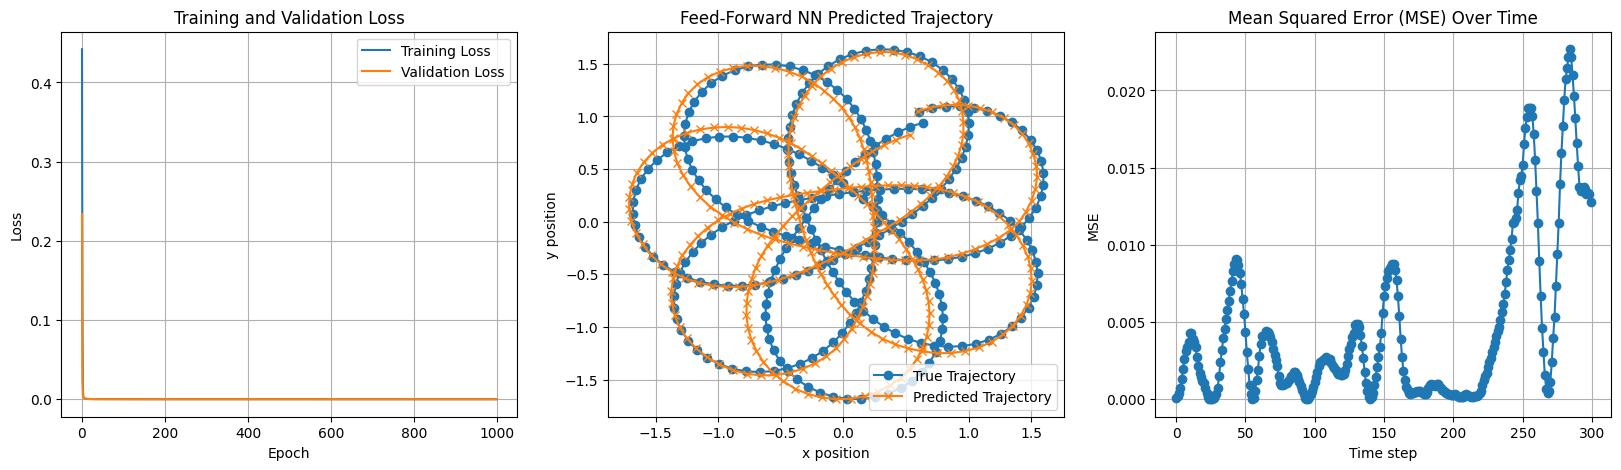

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import get_dataloaders
from src.network import FeedForwardNN, RecurrentNN
from train import train_model, evaluate_model
from plotting import extract_initial_state_and_true_positions, plot_predicted_trajectories

batch_size = 64
num_epochs = 1000
seq_length = 1  # Single step sequence

# initialize figures for plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

train_loader, test_loader = get_dataloaders(batch_size, "data_lorentz/train.txt", "data_lorentz/test.txt", seq_length=seq_length)

# Instantiate the model, define loss function and optimizer
model = FeedForwardNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, test_loader, criterion, optimizer, ax1, num_epochs)
evaluate_model(model, test_loader, criterion)

# Extract initial state and true positions for iterative prediction
initial_state, true_positions = extract_initial_state_and_true_positions(test_loader, steps=300)


# Plot predicted trajectories using the model iteratively
predicted_positions = plot_predicted_trajectories(model, initial_state, true_positions, 'Feed-Forward NN Predicted Trajectory', axisPlt=ax2)

# Calculate and plot mean squared error (MSE) as a function of time
# mse = np.mean((true_positions - np.array(predicted_positions)) ** 2, axis=1)
mse = np.mean((np.array(np.subtract(true_positions,predicted_positions))) ** 2, axis=1)

ax3.plot(mse, marker='o')
ax3.set_title('Mean Squared Error (MSE) Over Time')
ax3.set_xlabel('Time step')
ax3.set_ylabel('MSE')
ax3.grid(True)
plt.show()


## Recurrent NN

Epoch 100/100, Loss: 0.0001: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


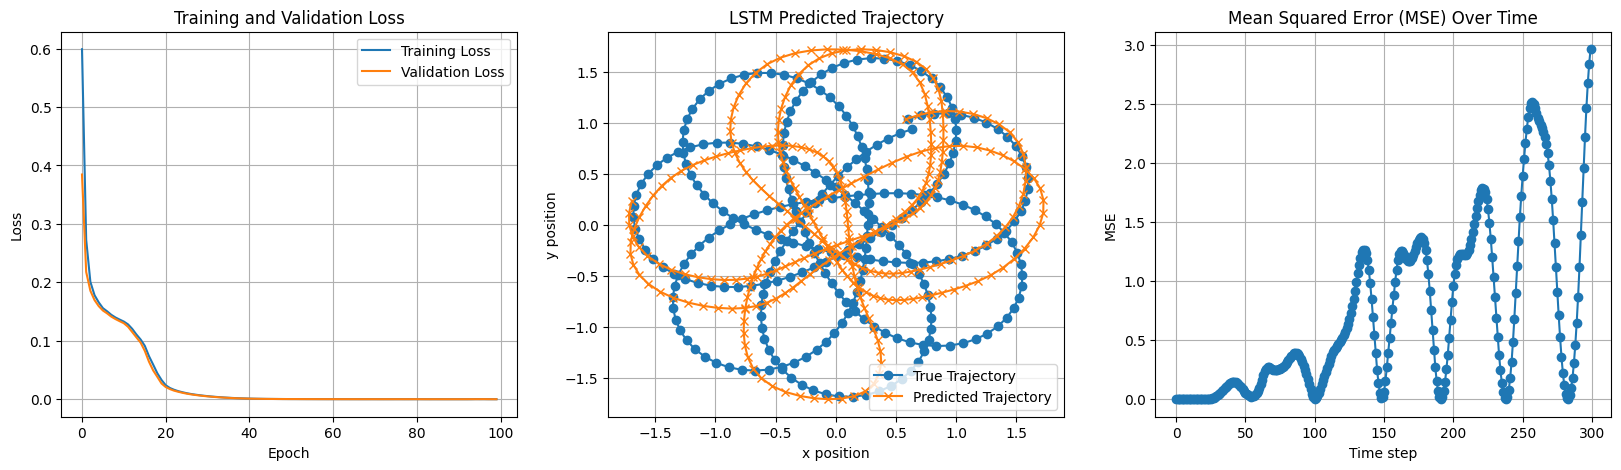

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import get_dataloaders_LSTM
from src.network import RecurrentNN
from train import train_model, evaluate_model
from tqdm.auto import tqdm
from plotting import extract_initial_state_and_true_positions_LSTM, plot_predicted_trajectories_LSTM

batch_size = 64
num_epochs = 100
seq_length = 16  # Single step sequence

# initialize figures for plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Get dataloaders
train_loader, test_loader = get_dataloaders_LSTM(batch_size, "data_lorentz/train.txt", "data_lorentz/test.txt", seq_length=seq_length)

# Instantiate the LSTM model, define loss function and optimizer
rnn_model = RecurrentNN(input_size=4, hidden_size=64, output_size=4, num_layers=4)
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Train the LSTM model
train_model(rnn_model, train_loader,test_loader, criterion, optimizer, ax1, num_epochs=num_epochs)
# Evaluate the LSTM model
evaluate_model(rnn_model, test_loader, criterion)

# Extract initial state and true positions for iterative prediction
initial_state, true_positions = extract_initial_state_and_true_positions_LSTM(test_loader, steps=300)

# Plot predicted trajectories using the model iteratively
predicted_positions = plot_predicted_trajectories_LSTM(rnn_model, initial_state, true_positions, 'LSTM Predicted Trajectory', ax2, steps=300)

# Calculate and plot mean squared error (MSE) as a function of time
# mse = np.mean((true_positions - predicted_positions) ** 2, axis=1)
mse = np.mean((np.array(np.subtract(true_positions,predicted_positions))) ** 2, axis=1)

ax3.plot(mse, marker='o')
ax3.set_title('Mean Squared Error (MSE) Over Time')
ax3.set_xlabel('Time step')
ax3.set_ylabel('MSE')
ax3.grid(True)
plt.show()



## Physics informed Feed Forward NN

Training standard NN


Epoch 1000/1000, Training Loss: 0.7840, Validation Loss: 0.4827: 100%|██████████| 1000/1000 [03:19<00:00,  5.01it/s]


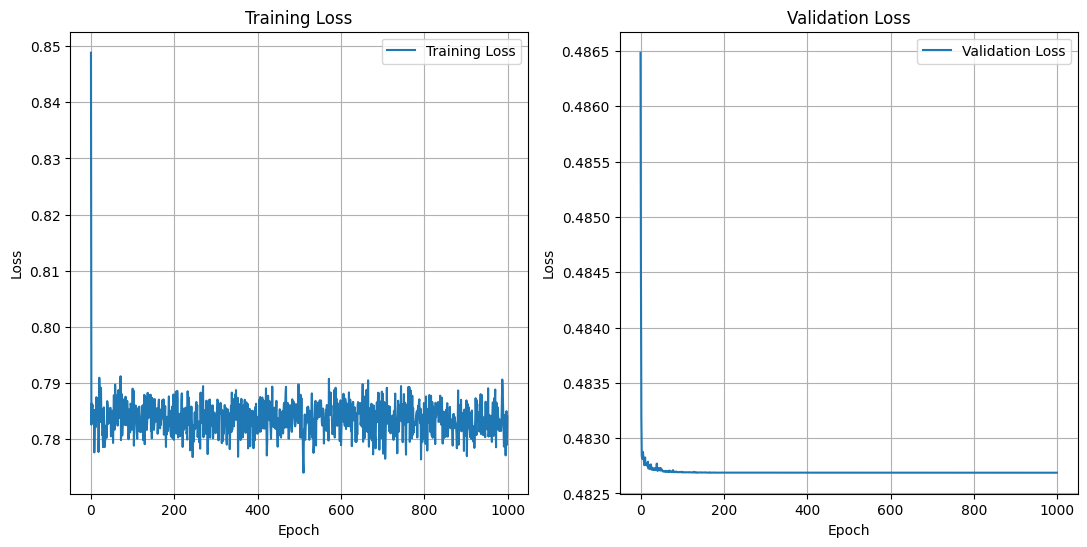

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import get_dataloaders
from src.network import FeedForwardNN
from train import train_model, evaluate_model
from tqdm.auto import tqdm
import torch.autograd as ag

epochs = 1000
n_data = 300
batch_size=64

## ------------------ set up models-------------------------- ##
# set network size
n_in = 4 # 2 channels position and 2 channels velocity
n_h1 = 100
n_h2 = 50
n_o = 4 # 2 channels for position and 2 channels for velocity at next time step

# Get dataloaders
train_loader, test_loader = get_dataloaders(batch_size, "data_lorentz/train.txt", "data_lorentz/test.txt")

# Define the physics-informed neural network
model = torch.nn.Sequential(
    torch.nn.Linear(n_in, n_h1),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h1, n_h2),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h2, n_o),
)


# ---------------  Set up and train the uncconstrained model -------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10,
                                                     min_lr=1e-10,
                                                    factor=0.5,
                                                    cooldown=15)

criterion=nn.MSELoss()

def callculateStep(input_states):
    
    batch_size = input_states.size(0)
    x = input_states[:, 0:2]
    v = input_states[:, 2:4]

    q=1
    m=1
    
    B_x = torch.zeros(batch_size, 2)
    B_x = torch.cat((B_x, torch.sqrt(x[:, 0]**2 + x[:, 1]**2).view(-1,1)),1).view(-1,1,3)

    B_hat = torch.zeros((B_x.shape[0], 3, 3))
    
    B_hat[:,0,1] = - B_x[:,0,2]
    B_hat[:,0,2] = B_x[:,0,1]
    B_hat[:,1,2] = - B_x[:,0,0]
    
    B_hat[:,1,0] = B_x[:,0,2]
    B_hat[:,2,0] = - B_x[:,0,1]
    B_hat[:,2,1] = B_x[:,0,0]

    # H - magnetic field strength, phi electric potential
    # phi = 1/100/torch.sqrt(x[:,0]**2 + x[:,1]**2)
    # H = 1/2 * torch.einsum('ij,ij->i', v, v) * m + q * phi
    # calculate delta H
    
    deltaH = torch.zeros(batch_size, 6)
    deltaH[:,0] = m * v[:,0]
    deltaH[:,1] = m * v[:,1]

    deltaH[:,3] = q * x[:,0]/100 / torch.sqrt(x[:,0]**2 + x[:,1]**2) **3
    deltaH[:,4] = q * x[:,1]/100 / torch.sqrt(x[:,0]**2 + x[:,1]**2) **3

    vx_matrix = torch.zeros((batch_size, 6, 6))
    vx_matrix[:,0:3,0:3] = -q/m**2 * B_hat
    vx_matrix[:,0:3,3:6] = -1/m *torch.eye(3).unsqueeze(0).expand(batch_size, 3, 3) 
    vx_matrix[:,3:6,0:3] = 1/m * torch.eye(3).unsqueeze(0).expand(batch_size, 3, 3)

    dvdx = torch.einsum('ijk,ik->ij',vx_matrix, deltaH)

    dv = dvdx[:,0:3]
    dx = dvdx[:,3:6]
    
    return dvdx  

def train(epoch):
    model.train()
    total_loss = 0
    n_batches = 0
    for input_states, output_states in train_loader:
        optimizer.zero_grad()
        
        x_train = input_states
        yhat = model(x_train)
        
        y_train = output_states

        dvdx = callculateStep(input_states)
        
        loss = criterion(y_train, yhat) + criterion(x_train+dvdx[:, [0,1,3,4] ], y_train)


        loss.backward()
        optimizer.step()
        total_loss += loss.cpu()
        n_batches += 1
    return total_loss / n_batches

def eval(epoch):
    model.eval()
    for input_states, output_states in test_loader:
        with torch.no_grad():
            yhat = model(input_states)
            dvdx = callculateStep(input_states)
            loss = criterion(output_states, yhat)  + criterion(input_states+dvdx[:, [0,1,3,4] ], output_states)
            # + criterion(input_states+dvdx, output_states)
    return loss.cpu()


train_loss = np.empty([epochs, 1])
val_loss = np.empty([epochs, 1])


print('Training standard NN')

progress_bar = tqdm(range(epochs))    

for epoch in progress_bar:
    train_loss[epoch] = train(epoch).detach().numpy()
    v_loss = eval(epoch)
    scheduler.step(v_loss)
    val_loss[epoch] = v_loss.detach().numpy()
    progress_bar.set_description(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss[epoch][0]:.4f}, Validation Loss: {val_loss[epoch][0]:.4f}')
    

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

# Plot training loss in the first subplot
ax1.plot(train_loss, label='Training Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot validation loss in the second subplot
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Show the figure
plt.show()


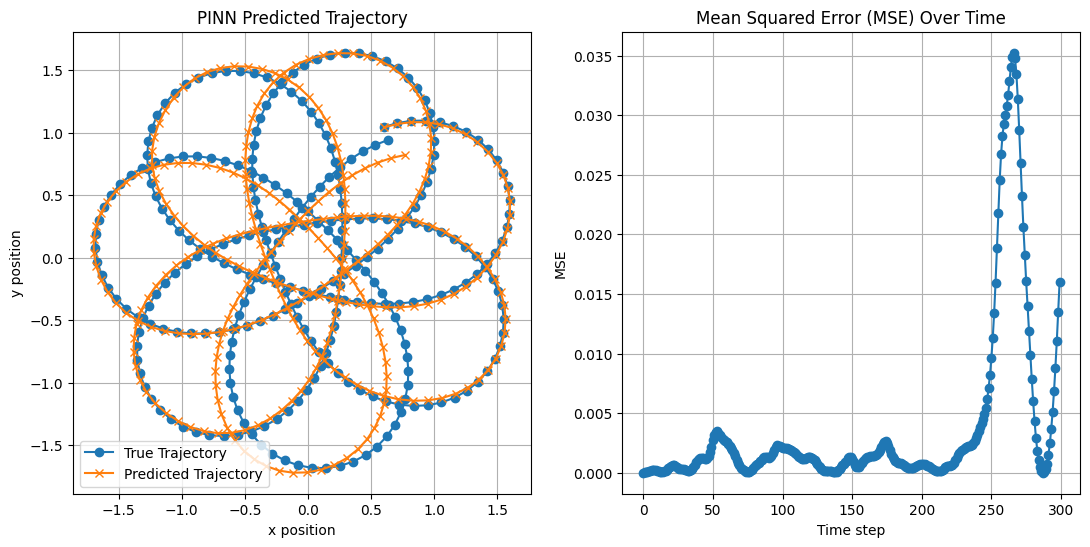

In [4]:
from plotting import plot_predicted_trajectories, extract_initial_state_and_true_positions

# initialize figures for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

# Extract initial state and true positions for iterative prediction
initial_state, true_positions = extract_initial_state_and_true_positions(test_loader, steps=300)

# Plot predicted trajectories using the model iteratively
predicted_positions = plot_predicted_trajectories(model, initial_state, true_positions, 'PINN Predicted Trajectory', ax1, steps=300)

# Calculate and plot mean squared error (MSE) as a function of time
mse = torch.mean((true_positions - torch.tensor(predicted_positions)) ** 2, axis=1)

ax2.plot(mse, marker='o')
ax2.set_title('Mean Squared Error (MSE) Over Time')
ax2.set_xlabel('Time step')
ax2.set_ylabel('MSE')
ax2.grid(True)
plt.show()



### Redo for consistency testing

Training standard NN


Epoch 1000/1000, Training Loss: 0.7823, Validation Loss: 0.4827: 100%|██████████| 1000/1000 [03:14<00:00,  5.13it/s]


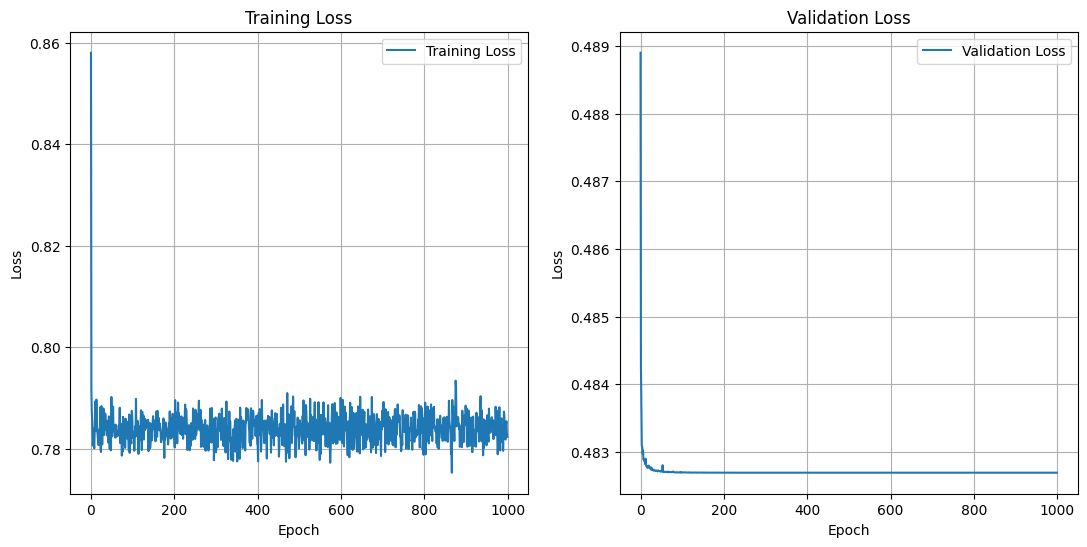

In [5]:
# Define the physics-informed neural network
model = torch.nn.Sequential(
    torch.nn.Linear(n_in, n_h1),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h1, n_h2),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h2, n_o),
)


# ---------------  Set up and train the uncconstrained model -------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10,
                                                     min_lr=1e-10,
                                                    factor=0.5,
                                                    cooldown=15)

criterion=nn.MSELoss()
train_loss = np.empty([epochs, 1])
val_loss = np.empty([epochs, 1])


print('Training standard NN')

progress_bar = tqdm(range(epochs))    

for epoch in progress_bar:
    train_loss[epoch] = train(epoch).detach().numpy()
    v_loss = eval(epoch)
    scheduler.step(v_loss)
    val_loss[epoch] = v_loss.detach().numpy()
    progress_bar.set_description(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss[epoch][0]:.4f}, Validation Loss: {val_loss[epoch][0]:.4f}')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

# Plot training loss in the first subplot
ax1.plot(train_loss, label='Training Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot validation loss in the second subplot
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Show the figure
plt.show()

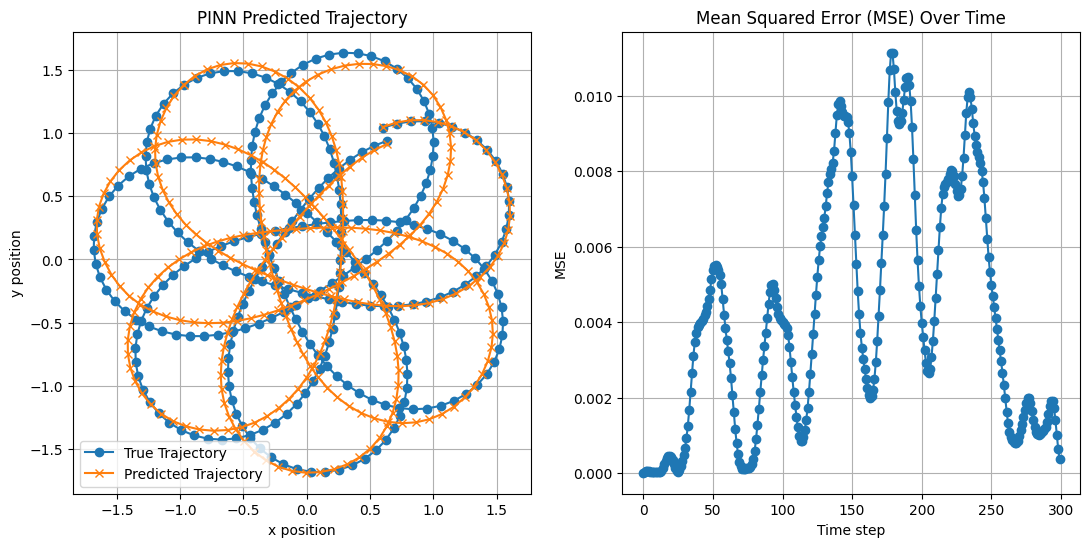

In [6]:
from plotting import plot_predicted_trajectories, extract_initial_state_and_true_positions

# initialize figures for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

# Extract initial state and true positions for iterative prediction
initial_state, true_positions = extract_initial_state_and_true_positions(test_loader, steps=300)

# Plot predicted trajectories using the model iteratively
predicted_positions = plot_predicted_trajectories(model, initial_state, true_positions, 'PINN Predicted Trajectory', ax1, steps=300)

# Calculate and plot mean squared error (MSE) as a function of time
mse = torch.mean((true_positions - torch.tensor(predicted_positions)) ** 2, axis=1)

ax2.plot(mse, marker='o')
ax2.set_title('Mean Squared Error (MSE) Over Time')
ax2.set_xlabel('Time step')
ax2.set_ylabel('MSE')
ax2.grid(True)
plt.show()

## Raj feedback


dont use rnn besause of eploding grdaient lstm, 

use simplictic NN

VPT - check in simpnet paper

Hamiltoninan system - no right deffinition of the long time

## Symplectic-Neural-Networks-(SympNet):-Pendulum-System

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import learner as ln
from learner.integrator.hamiltonian import SV

DIM=2

class PDData(ln.Data):
    '''Data for learning the pendulum system with the Hamiltonian H(p,q)=(1/2)p^2−cos(q).
    '''
    def __init__(self, x0, h, train_num, test_num, add_h=False):
        super(PDData, self).__init__()
        self.dH = lambda p, q: (p, np.sin(q))
        self.solver = SV(None, self.dH, iterations=1, order=6, N=10)
        self.x0 = x0
        self.h = h
        self.train_num = train_num
        self.test_num = test_num
        self.add_h = add_h
        self.__init_data()
        
    @property
    def dim(self):
        return DIM
    
    def __generate_flow(self, x0, h, num):
        X = self.solver.flow(np.array(x0), h, num)
        x, y = X[:-1], X[1:]
        if self.add_h:
            x = np.hstack([x, self.h * np.ones([x.shape[0], 1])])
        return x, y
    
    def __init_data(self):
        self.X_train, self.y_train = self.__generate_flow(self.x0, self.h, self.train_num)
        self.X_test, self.y_test = self.__generate_flow(self.y_train[-1], self.h, self.test_num)
        
def plot(data, net):
    steps = 1000
    if isinstance(net, ln.nn.HNN):
        flow_true = data.solver.flow(data.X_test_np[0][:-1], data.h, steps)
        flow_pred = net.predict(data.X_test[0][:-1], data.h, steps, keepinitx=True, returnnp=True)
    else:
        flow_true = data.solver.flow(data.X_test_np[0], data.h, steps)
        flow_pred = net.predict(data.X_test[0], steps, keepinitx=True, returnnp=True)
    
    plt.plot(flow_true[:, 0], flow_true[:, 1], color='b', label='Ground truth', zorder=0)
    plt.plot(flow_pred[:, 0], flow_pred[:, 1], color='r', label='Predicted flow', zorder=1)
    plt.scatter(data.X_train_np[:, 0], data.X_train_np[:, 1], color='b', label='Learned data', zorder=2)
    plt.xlabel("q")
    plt.ylabel("p")
    plt.legend()
    plt.savefig('pendulum.pdf')

def main():
    device = 'cpu' # 'cpu' or 'gpu'
    # data
    x0 = [0, 1]
    h = 0.1
    train_num = 40
    test_num = 100
    # net
    net_type = 'LA' # 'LA' or 'G' or 'HNN'
    LAlayers = 3
    LAsublayers = 2
    Glayers = 5
    Gwidth = 30
    activation = 'sigmoid'
    Hlayers = 4
    Hwidth = 30
    Hactivation = 'tanh'
    # training
    lr = 0.001
    iterations = 50000
    print_every = 1000
    
    add_h = True if net_type == 'HNN' else False
    criterion = None if net_type == 'HNN' else 'MSE'
    data = PDData(x0, h, train_num, test_num, add_h)
    if net_type == 'LA':
        net = ln.nn.LASympNet(data.dim, LAlayers, LAsublayers, activation)
    elif net_type == 'G':
        net = ln.nn.GSympNet(data.dim, Glayers, Gwidth, activation)
    elif net_type == 'HNN':
        net = ln.nn.HNN(data.dim, Hlayers, Hwidth, Hactivation)
    args = {
        'data': data,
        'net': net,
        'criterion': criterion,
        'optimizer': 'adam',
        'lr': lr,
        'iterations': iterations,
        'batch_size': None,
        'print_every': print_every,
        'save': True,
        'callback': None,
        'dtype': 'float',
        'device': device
    }
    
    ln.Brain.Init(**args)
    ln.Brain.Run()
    ln.Brain.Restore()
    ln.Brain.Output()
    
    plot(data, ln.Brain.Best_model())
    
if __name__ == '__main__':
    main()